# Востановление плотностей распределения

## Библиотеки

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from copy import deepcopy
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
from scipy import stats
import numpy as np
from sklearn import tree, base
import itertools
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, BaggingClassifier)
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.datasets import make_classification, make_regression, load_wine, load_boston
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
import torch

from mixturelib.mixture import MixtureEM
from mixturelib.local_models import EachModelLinear
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Принцип максимума правдоподобия

Если $P\bigr(y\bigr)$ равномерная случайная величина, то
$$
a\bigr(x\bigr) = \arg\max_{y\in Y} p\bigr(x|y\bigr)
$$

In [3]:
p_x_1 = stats.multivariate_normal([-1, -1], np.eye(2))
p_x_2 = stats.multivariate_normal([1, 1], 1.5*np.eye(2))

In [4]:
def plot():
    x = np.linspace(-3, 3, 300)
    y = np.linspace(-3, 3, 300)
    xs, ys = np.meshgrid(x, y)
    scores = [np.zeros_like(xs), np.zeros_like(xs)]
    for i in range(len(xs)):
        for j in range(len(xs[i])):
            scores[0][i][j] = p_x_1.pdf([xs[i][j],ys[i][j]])
            scores[1][i][j] = p_x_2.pdf([xs[i][j],ys[i][j]])

    ax = plt.figure(figsize=(14.0, 6.0)).gca(projection='3d')
    alpha=0.7
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] <= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] <= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] >= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] >= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.set_xlabel(r'x1', labelpad= 14), ax.set_ylabel(r'x2', labelpad=14)
    ax.set_zlabel(r'p(x)'), ax.view_init(30, -120)
    ax.view_init(30, -70)
    plt.show()

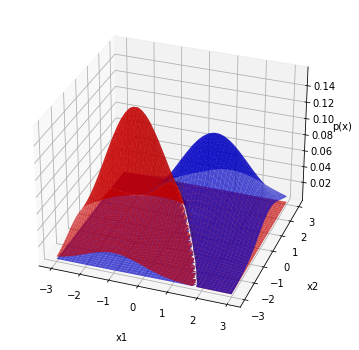

In [5]:
plot()

В случае, если плотности $p(x|y)$ заданы, то задача классификации является решенной. Но вопрос как найти $p(x|y)$?

## Одномерный случай

### Синтетические данные

Рассмотрим две гаусианы с разными средними и дисперсиями. Сгенерим выборку, где каждая гаусиана описывает свой класс.

In [6]:
np.random.seed(42)

l = 10000
p_x_1 = stats.norm(-1, 0.5)
x_1 = np.sqrt(0.5)*np.random.randn(l)-1
p_x_2 = stats.norm(1, 1.5)
x_2 = np.sqrt(1.5)*np.random.randn(l)+1

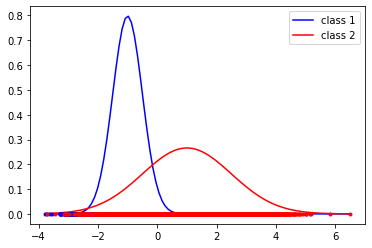

In [7]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x, p_x_1.pdf(x), color='blue', label='class 1')
plt.plot(x, p_x_2.pdf(x), color='red', label='class 2')
plt.plot(x_1, x_1*0, '.', color='blue')
plt.plot(x_2, x_2*0, '.', color='red')
plt.legend(loc='best')
plt.show()

### Востановления плотности по импирическим данным
Истинное распределение $p(x|y)$ не известно, востановим данную плотность $\hat{p}(x|y, \mathbf{X})$.

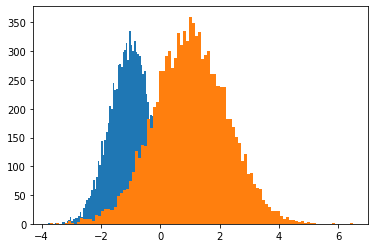

In [8]:
plt.hist(x_1, bins=100)
plt.hist(x_2, bins=100)

plt.show()

In [9]:
def p(x, D, h = 0.2):
    D = np.array(D)
    x = np.array(x)
    l = len(D)
    n = 1
    if len(D.shape) == 2:
        n = D.shape[1]
        
    D = D.reshape([-1, n])
    x = x.reshape([-1, n])
    return (1/(2*h))*(1/len(D))*(cdist(D, x, metric='minkowski', p=1) <= h).sum(axis=0)


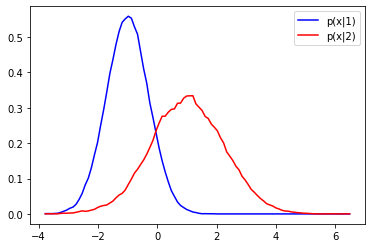

In [10]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x, p(x, x_1), color='blue', label='p(x|1)')
plt.plot(x, p(x, x_2), color='red', label='p(x|2)')
plt.legend(loc='best')
plt.show()

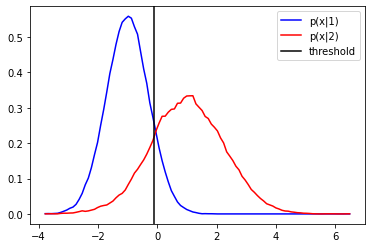

In [11]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x, p(x, x_1), color='blue', label='p(x|1)')
plt.plot(x, p(x, x_2), color='red', label='p(x|2)')

plt.axvline(-0.1, color='black', label='threshold')

plt.legend(loc='best')
plt.show()

### LOO для выбора ширины окна

In [12]:
def LOO(D, h):
    D_list = D.tolist()
    
    for i in range(len(D_list)):
        return -np.log(p([D_list[i]], D_list[:i]+D_list[i+1:], h)).sum()

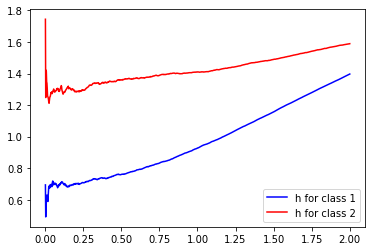

In [13]:
hs = np.linspace(1e-10, 2, 1000)
scores_1 = [LOO(x_1, h) for h in hs]
scores_2 = [LOO(x_2, h) for h in hs]

plt.plot(hs, scores_1, color='blue', label='h for class 1')
plt.plot(hs, scores_2, color='red', label='h for class 2')

plt.legend(loc='best')
plt.show()

In [14]:
hs[np.argmin(scores_1)], hs[np.argmin(scores_2)]

(0.0040040041038038035, 0.026026026124724728)

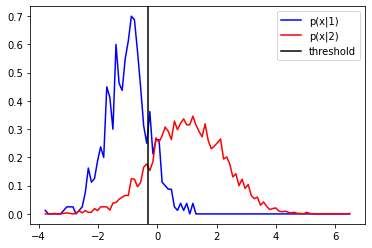

In [15]:
x = np.linspace(min(np.min(x_1), np.min(x_2)), 
                max(np.max(x_1), np.max(x_2)), 100)

plt.plot(x, p(x, x_1, hs[np.argmin(scores_1)]), color='blue', label='p(x|1)')
plt.plot(x, p(x, x_2, hs[np.argmin(scores_2)]), color='red', label='p(x|2)')

plt.axvline(-0.3, color='black', label='threshold')

plt.legend(loc='best')
plt.show()

## Двумерный случай

In [16]:
np.random.seed(42)

l = 10000
p_x_1 = stats.multivariate_normal([-1, -1], 0.5*np.eye(2))
x_1 = np.sqrt(0.5)*np.random.randn(l, 2)+np.array([-1, -1])
p_x_2 = stats.multivariate_normal([1, 1], 1.5*np.eye(2))
x_2 = np.sqrt(1.5)*np.random.randn(l, 2)+np.array([1, 1])

In [17]:
def plot():
    x = np.linspace(-3, 3, 300)
    y = np.linspace(-3, 3, 300)
    xs, ys = np.meshgrid(x, y)
    scores = [np.zeros_like(xs), np.zeros_like(xs)]
    for i in range(len(xs)):
        for j in range(len(xs[i])):
            scores[0][i][j] = p_x_1.pdf([xs[i][j],ys[i][j]])
            scores[1][i][j] = p_x_2.pdf([xs[i][j],ys[i][j]])

    ax = plt.figure(figsize=(14.0, 6.0)).gca(projection='3d')
    alpha=0.7
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] <= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] <= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] >= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] >= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.set_xlabel(r'x1', labelpad= 14), ax.set_ylabel(r'x2', labelpad=14)
    ax.set_zlabel(r'p(x)'), ax.view_init(30, -120)
    ax.view_init(30, -70)
    plt.show()

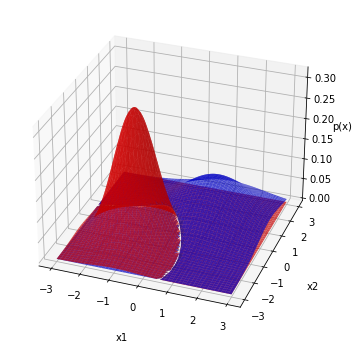

In [18]:
plot()

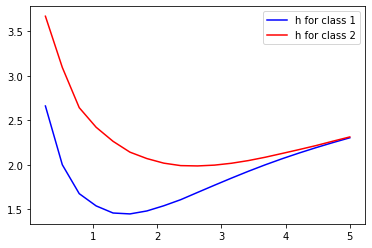

In [19]:
hs = np.linspace(1e-10, 5, 20)
scores_1 = [LOO(x_1, h) for h in hs]
scores_2 = [LOO(x_2, h) for h in hs]

plt.plot(hs, scores_1, color='blue', label='h for class 1')
plt.plot(hs, scores_2, color='red', label='h for class 2')

plt.legend(loc='best')
plt.show()

In [20]:
hs[np.argmin(scores_1)], hs[np.argmin(scores_2)]

(1.578947368489474, 2.6315789474157896)

In [21]:
def plot():
    x = np.linspace(-3, 3, 300)
    y = np.linspace(-3, 3, 300)
    xs, ys = np.meshgrid(x, y)
    scores = [np.zeros_like(xs), np.zeros_like(xs)]
    for i in range(len(xs)):
        line = np.array([[xs[i][j],ys[i][j]] for j in range(len(xs[i]))])
        scores[0][i] = p(line, x_1, hs[np.argmin(scores_1)])
        scores[1][i] = p(line, x_2, hs[np.argmin(scores_2)])

    ax = plt.figure(figsize=(14.0, 6.0)).gca(projection='3d')
    alpha=0.7
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] <= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] <= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[1] >= scores[0], scores[1], np.nan),
                    linewidth=0, color='blue', alpha=alpha)
    ax.plot_surface(xs, ys, 
                    np.where(scores[0] >= scores[1], scores[0], np.nan), 
                    linewidth=0, color='red', alpha=alpha)
    ax.set_xlabel(r'x1', labelpad= 14), ax.set_ylabel(r'x2', labelpad=14)
    ax.set_zlabel(r'p(x)'), ax.view_init(30, -120)
    ax.view_init(30, -70)
    plt.show()

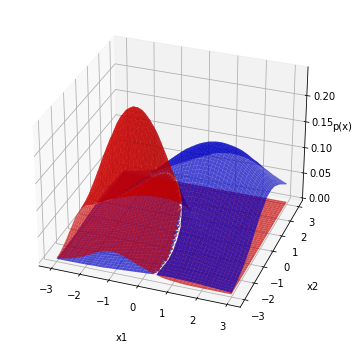

In [22]:
plot()

## Параметрическое востановление плотности

### Принцип максимума правдоподобия

$$
\hat{\theta} = \arg\max_{\theta}L\bigr(\theta, \mathbf{X}^{m}\bigr) = \sum_{i=1}^{m}\ln p\bigr(x_i| \theta\bigr)
$$

Пример для нормального распределения:
$$
\mu = \frac{1}{m}\sum_{i=1}^{m}x_i.
$$

## Смесь распределений

In [23]:
color = ['blue', 'red']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [24]:
np.random.seed(42)

N = 200
noise_component = 0.8
noise_target = 5

X = np.random.randn(N, 2)
X[:N//2, 1] *= noise_component
X[:N//2] += np.array([-2,-2])
X[N//2:, 0] *= noise_component
X[N//2:] += np.array([2,2])

real_first_w = np.array([[10.], [0.]])
real_second_w = np.array([[0.], [30.]])

y = np.vstack([X[:N//2]@real_first_w, X[N//2:]@real_second_w])\
    + noise_target*np.random.randn(N, 1)

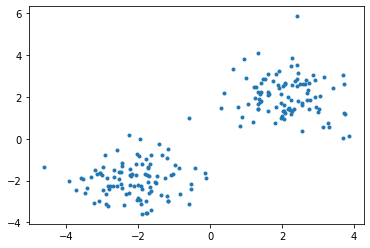

In [25]:
plt.plot(X[:, 0], X[:, 1], '.')

plt.show()

In [26]:
torch.random.manual_seed(42)
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(y)

In [27]:
torch.random.manual_seed(42)
first_model = EachModelLinear(input_dim=2)
secode_model = EachModelLinear(input_dim=2)

list_of_models = [first_model, secode_model]

In [28]:
HpMd = HyperExpertNN(input_dim=2, hidden_dim=5,
                     output_dim=2, epochs=100)

In [29]:
mixture = MixtureEM(HyperParameters={'beta': 1.},
                    HyperModel=HpMd,
                    ListOfModels=list_of_models,
                    model_type='sample')

In [30]:
List_of_ind=[]
List_of_W=[]
for _ in tqdm(range(10)):
    mixture.fit(X_tr, Y_tr, 1)
    List_of_ind.append(np.argmax(mixture.predict(X_tr)[1], axis = 1))
    List_of_W.append(np.array([m.W.data.numpy().reshape(-1) for m in mixture.ListOfModels]))
    
List_of_ind = np.array(List_of_ind)
List_of_W = np.array(List_of_W)

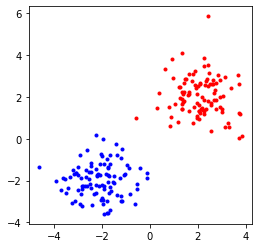

In [31]:
fig = plt.figure(figsize=(4.0, 4.0))

pred_type = np.argmax(mixture.predict(X_tr)[1], axis=-1)

for i in np.unique(pred_type):
    plt.plot(X[pred_type==i, 0], X[pred_type==i, 1], '.', color=color[i], label='type {}'.format(i))
    
plt.show()

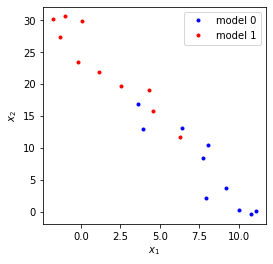

In [32]:
fig = plt.figure(figsize=(4.0, 4.0))

for i in range(List_of_W.shape[1]):
    plt.plot(List_of_W[:, i, 0], List_of_W[:, i, 1], '.', color=color[i], label='model {}'.format(i))

plt.legend(loc='best')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

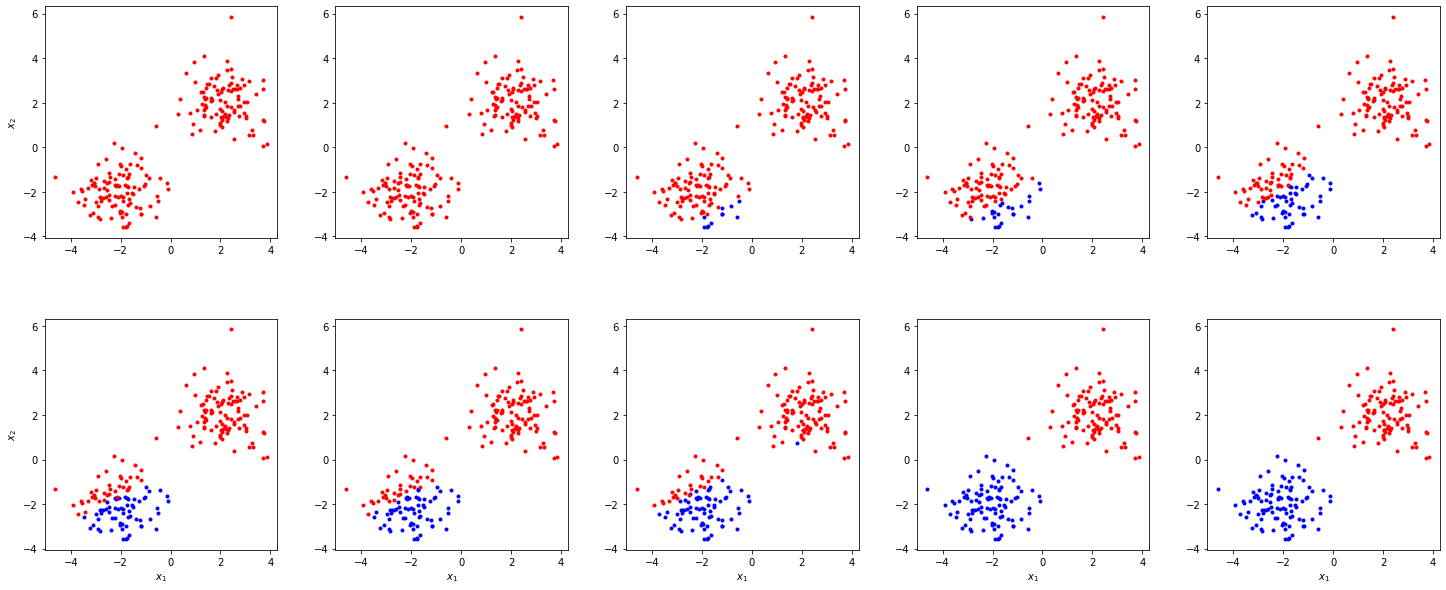

In [33]:
fig = plt.figure(figsize=(25.0, 10.0))
gs = gridspec.GridSpec(2, 5)
ax = []
for i, g in enumerate(gs):
    ax.append(fig.add_subplot(g))
    if (len(ax) - 1) % 5 == 0:
        ax[-1].set_ylabel('$x_2$')
    if len(ax) > 5:
        ax[-1].set_xlabel('$x_1$')
for e, (idx, _) in enumerate(zip(List_of_ind[:10], List_of_W[:10])):
    for i in np.unique(idx):
        indexes = np.where(idx == i)
        _ = ax[e].plot(X[indexes, 0], X[indexes, 1], '.', color=color[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.show()